# Domain rank correlation

## Load data from Gaffer

In [1]:
import requests
import json
import sys
import gaffer
import threatgraph
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Number of 'top domains'
n = 10

In [3]:
g = threatgraph.Gaffer()
g.use_cert()

In [4]:
op = gaffer.OperationChain([
    gaffer.GetAllElements(entities=[
        gaffer.ViewGroup("device", exclude=["count", "time"])
    ], edges=None),
    gaffer.GetWalks(
        operations=[
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("hasip", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ]), 
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("dnsquery")
                ], entities=None, include="OUTGOING")
            ]), 
             gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("indomain", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ])
        ],
        limit=10000000)
])

query = op.encode()
res = g.execute_chunked(op)

things = {}
timestamps = {}
counts = {}

all_things = set()
all_devices = set()

for v in res:

    try:
        ent = json.loads(v)

    except Exception:
        continue

    dev = list(ent["entities"][0].keys())[0]
    thing = list(ent["entities"][3].keys())[0]
    
    k = (dev, thing)

    if not k in counts:
        counts[k] = 0
        timestamps[k] = set()
        
    if not dev in things:
        things[dev] = set()

    ts = ent["edges"][1][0]["properties"]["time"]["uk.gov.gchq.gaffer.time.RBMBackedTimestampSet"]["timestamps"]
    cnt = ent["edges"][1][0]["properties"]["count"]

    counts[k] += cnt
    timestamps[k].update(ts)
    things[dev].add(thing)
    all_things.add(thing)
    all_devices.add(dev)

In [5]:
all_devices = list(all_devices)
all_things = list(all_things)

## Construct domain to device matrix

In [6]:
def get_counts(thing, dev):
    if thing in things[dev]: return counts[(dev, thing)]
    return 0

datas = [ [ get_counts(thing, dev) for dev in all_devices ] for thing in all_things]
df = pd.DataFrame(datas, index=all_things, columns=all_devices)

# Add a score column
df["score"] = df.sum(axis=1)
df

,turing-minimacbook,calcannea-mac,mark-mac,ludicrous-mac,castle3b7c9f,turing-macbook,DESKTOP-PIMD8C0,elysium-mac,dramatic-mac,rarb-mac,...,abroad-android,simon-macpro,essential-mac,LAPTOP-1I501C4U,misskitty-mac,theatergoing-mac,boundless-mac,essential-chrome,daniel-chromebook,score
outeast.com,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
stride.com,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,0,1,0,0,5
onthe.io,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,8
td553.com,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
xwcwllwrin.openvpn,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,2
comodoca4.com,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
iotacdn.net,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,5
pep8.org,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
wac.kz,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,6
mediabong.com,0,0,0,0,0,0,0,0,36,0,...,0,0,0,0,0,0,0,0,0,36


## Get list of highest accessed domains by all devices

In [7]:
top_domains = df.sort_values(by="score", ascending=False).index.values[:n]
top_domains

array(['google.com', 'gstatic.com', 'trustnetworks.com', 'googleapis.com',
       'apple.com', 'in-addr.arpa', 'clubhouse.io', 'akadns.net',
       'doubleclick.net', 'netgear.com'], dtype=object)

## Spearman's Rho

In [8]:
# Calculate Rho on 2 lists
def spearman(a, b):
    
    n = len(a)
    bmap = {b[i]: i for i in range(0, len(b)) }

    tot = 0
    for i in range(0, len(a)):
        if a[i] in bmap:
            val = bmap[a[i]] - i
        else:
            val = len(b)
        val = val * val
        
        tot += val
    return 1.0 - ( (6 * tot) / ( n * (n * n - 1) ) )

## Get favourite domains by device

In [9]:
fav_domains = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]
fav_domains

[['turing-minimacbook',
  array(['google.com', 'apple.com', 'akadns.net', 'in-addr.arpa',
         'apple-dns.net', 'gstatic.com', 'googleapis.com',
         'googleusercontent.com', 'akamaiedge.net', 'icloud.com'],
        dtype=object)],
 ['calcannea-mac',
  array(['google.com', 'googleapis.com', 'slack.com', 'crashlytics.com',
         'gvt2.com', 'bbc.co.uk', 'bbci.co.uk', 'oneplus.net',
         'slack-msgs.com', 'slack-edge.com'], dtype=object)],
 ['mark-mac',
  array(['facebook.com', 'virustotal.com', 'google.com', 'twisted.ru',
         'bbc.co.uk', 'trustnetworks.com', 'gstatic.com',
         'fedoraproject.org', 'apple.com', 'clubhouse.io'], dtype=object)],
 ['ludicrous-mac',
  array(['in-addr.arpa', 'google.com', 'apple.com', 'utun1.viscosity',
         'googleapis.com', 'gstatic.com', '1password.com', 'icloud.com',
         'slack.com', 'akadns.net'], dtype=object)],
 ['castle3b7c9f',
  array(['netgear.com', 'outeast.com', 'zdbb.net', 'aeturnum.com',
         'coderwall.com

In [10]:
df2 = pd.DataFrame(fav_domains, columns=["device", "domains"]).set_index("device")
df2

,domains
device,
turing-minimacbook,"[google.com, apple.com, akadns.net, in-addr.ar..."
calcannea-mac,"[google.com, googleapis.com, slack.com, crashl..."
mark-mac,"[facebook.com, virustotal.com, google.com, twi..."
ludicrous-mac,"[in-addr.arpa, google.com, apple.com, utun1.vi..."
castle3b7c9f,"[netgear.com, outeast.com, zdbb.net, aeturnum...."
turing-macbook,"[google.com, apple.com, in-addr.arpa, akadns.n..."
DESKTOP-PIMD8C0,"[microsoft.com, trustnetworks.com, mcafee.com,..."
elysium-mac,"[google.com, gstatic.com, googleapis.com, goog..."
dramatic-mac,"[google.com, apple.com, rbxcdn.com, in-addr.ar..."


## Compute Spearman co-efficient
against most common domains

In [11]:
df2["coefficient"] = df2["domains"].apply(lambda x: spearman(x, top_domains)).round(2)

In [12]:
df2.sort_values(by="coefficient", ascending=False)[["domains", "coefficient"]]

,domains,coefficient
device,,
minesweepers-mac,"[google.com, github.com, in-addr.arpa, clubhou...",-0.48
tirasse-mac,"[google.com, in-addr.arpa, gstatic.com, clubho...",-1.00
languid-mac,"[google.com, in-addr.arpa, apple.com, gstatic....",-1.11
misskitty-mac,"[google.com, akadns.net, googleapis.com, gstat...",-1.17
dgmac,"[google.com, clubhouse.io, apple.com, trustnet...",-1.18
theatergoing-mac,"[trustnetworks.com, google.com, microsoft.com,...",-1.31
elysium-mac,"[google.com, gstatic.com, googleapis.com, goog...",-1.48
terrestrial-mac,"[google.com, gstatic.com, apple.com, googleapi...",-1.51
serotinal-mac,"[google.com, googleapis.com, in-addr.arpa, gst...",-1.55


## Device to device co-efficient

In [13]:
everyone = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]
df3 = pd.DataFrame(fav_domains, columns=["device", "domains"]).set_index("device")
for dev, domains in everyone:
    df3[dev] = df3["domains"].apply(lambda x: spearman(domains, x)).round(2)

In [14]:
df3

,domains,turing-minimacbook,calcannea-mac,mark-mac,ludicrous-mac,castle3b7c9f,turing-macbook,DESKTOP-PIMD8C0,elysium-mac,dramatic-mac,...,terrestrial-mac,abroad-android,simon-macpro,essential-mac,LAPTOP-1I501C4U,misskitty-mac,theatergoing-mac,boundless-mac,essential-chrome,daniel-chromebook
device,,,,,,,,,,,,,,,,,,,,,
turing-minimacbook,"[google.com, apple.com, akadns.net, in-addr.ar...",1.00,-4.00,-3.57,-1.23,-5.06,-0.85,-3.00,-1.58,-2.05,...,-1.59,-2.79,-0.52,-2.87,-3.00,-1.82,-2.43,-2.12,-3.35,-2.87
calcannea-mac,"[google.com, googleapis.com, slack.com, crashl...",-4.00,1.00,-3.88,-3.52,-5.06,-4.00,-4.24,-2.94,-4.45,...,-3.48,-2.40,-3.45,-4.46,-4.24,-3.85,-3.45,-3.78,-2.67,-2.33
mark-mac,"[facebook.com, virustotal.com, google.com, twi...",-3.57,-3.88,1.00,-3.47,-5.06,-3.57,-3.37,-3.44,-3.57,...,-3.03,-3.44,-3.57,-4.24,-3.37,-3.42,-2.48,-3.12,-2.53,-3.38
ludicrous-mac,"[in-addr.arpa, google.com, apple.com, utun1.vi...",-1.23,-3.52,-3.47,1.00,-5.06,-1.73,-3.30,-1.35,-2.15,...,-1.63,-2.70,-1.62,-2.78,-3.30,-2.38,-1.75,-1.60,-2.82,-2.78
castle3b7c9f,"[netgear.com, outeast.com, zdbb.net, aeturnum....",-5.06,-5.06,-5.06,-5.06,1.00,-5.06,-5.06,-5.06,-5.06,...,-5.06,-5.06,-5.06,-5.06,-5.06,-5.06,-5.06,-5.06,-5.06,-5.06
turing-macbook,"[google.com, apple.com, in-addr.arpa, akadns.n...",-0.85,-4.00,-3.57,-1.73,-5.06,1.00,-3.05,-2.19,-2.64,...,-2.33,-3.45,-1.92,-3.25,-3.05,-1.99,-2.33,-2.15,-3.39,-3.49
DESKTOP-PIMD8C0,"[microsoft.com, trustnetworks.com, mcafee.com,...",-3.00,-4.24,-3.37,-3.30,-5.06,-3.05,1.00,-3.19,-3.56,...,-3.25,-3.08,-3.05,-4.20,1.00,-2.45,-1.68,-3.18,-3.16,-3.42
elysium-mac,"[google.com, gstatic.com, googleapis.com, goog...",-1.58,-2.94,-3.44,-1.35,-5.06,-2.19,-3.19,1.00,-3.10,...,-1.08,-1.74,-0.59,-3.62,-3.19,-1.79,-1.87,-2.12,-2.91,-2.16
dramatic-mac,"[google.com, apple.com, rbxcdn.com, in-addr.ar...",-2.05,-4.45,-3.57,-2.15,-5.06,-2.64,-3.56,-3.10,1.00,...,-2.28,-3.90,-3.03,-2.87,-3.56,-2.50,-3.33,-2.14,-3.90,-3.95


In [15]:
## Calculate log10(coefficient)
my_fn = lambda x: np.log10(x + 10)
df4 = df3.copy()
df4[all_devices] = df4[all_devices].apply(lambda x: [my_fn(v) for v in x]).round(2)

In [16]:
df4

,domains,turing-minimacbook,calcannea-mac,mark-mac,ludicrous-mac,castle3b7c9f,turing-macbook,DESKTOP-PIMD8C0,elysium-mac,dramatic-mac,...,terrestrial-mac,abroad-android,simon-macpro,essential-mac,LAPTOP-1I501C4U,misskitty-mac,theatergoing-mac,boundless-mac,essential-chrome,daniel-chromebook
device,,,,,,,,,,,,,,,,,,,,,
turing-minimacbook,"[google.com, apple.com, akadns.net, in-addr.ar...",1.04,0.78,0.81,0.94,0.69,0.96,0.85,0.93,0.90,...,0.92,0.86,0.98,0.85,0.85,0.91,0.88,0.90,0.82,0.85
calcannea-mac,"[google.com, googleapis.com, slack.com, crashl...",0.78,1.04,0.79,0.81,0.69,0.78,0.76,0.85,0.74,...,0.81,0.88,0.82,0.74,0.76,0.79,0.82,0.79,0.87,0.88
mark-mac,"[facebook.com, virustotal.com, google.com, twi...",0.81,0.79,1.04,0.81,0.69,0.81,0.82,0.82,0.81,...,0.84,0.82,0.81,0.76,0.82,0.82,0.88,0.84,0.87,0.82
ludicrous-mac,"[in-addr.arpa, google.com, apple.com, utun1.vi...",0.94,0.81,0.81,1.04,0.69,0.92,0.83,0.94,0.89,...,0.92,0.86,0.92,0.86,0.83,0.88,0.92,0.92,0.86,0.86
castle3b7c9f,"[netgear.com, outeast.com, zdbb.net, aeturnum....",0.69,0.69,0.69,0.69,1.04,0.69,0.69,0.69,0.69,...,0.69,0.69,0.69,0.69,0.69,0.69,0.69,0.69,0.69,0.69
turing-macbook,"[google.com, apple.com, in-addr.arpa, akadns.n...",0.96,0.78,0.81,0.92,0.69,1.04,0.84,0.89,0.87,...,0.88,0.82,0.91,0.83,0.84,0.90,0.88,0.89,0.82,0.81
DESKTOP-PIMD8C0,"[microsoft.com, trustnetworks.com, mcafee.com,...",0.85,0.76,0.82,0.83,0.69,0.84,1.04,0.83,0.81,...,0.83,0.84,0.84,0.76,1.04,0.88,0.92,0.83,0.84,0.82
elysium-mac,"[google.com, gstatic.com, googleapis.com, goog...",0.93,0.85,0.82,0.94,0.69,0.89,0.83,1.04,0.84,...,0.95,0.92,0.97,0.80,0.83,0.91,0.91,0.90,0.85,0.89
dramatic-mac,"[google.com, apple.com, rbxcdn.com, in-addr.ar...",0.90,0.74,0.81,0.89,0.69,0.87,0.81,0.84,1.04,...,0.89,0.79,0.84,0.85,0.81,0.88,0.82,0.90,0.79,0.78


## Plot it, heatmap

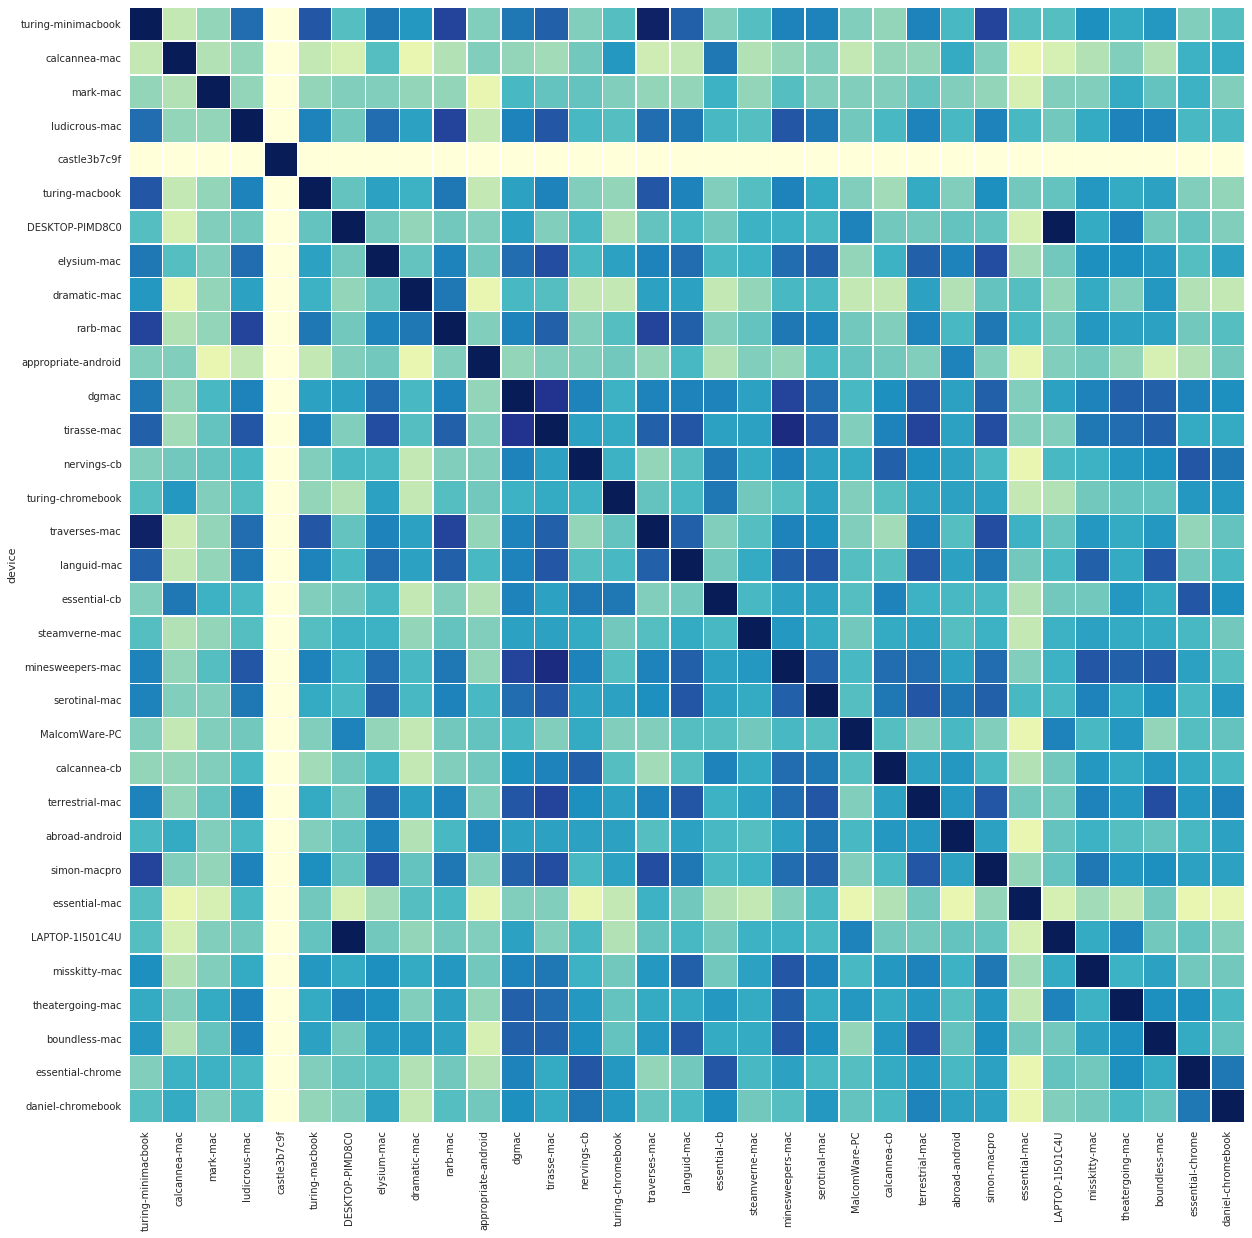

In [17]:
sns.set(style="white")
plt.figure(figsize=(20, 30))
sns.heatmap(df4[all_devices][all_devices], square=True, linewidths=0.5, cbar=False, cmap="YlGnBu")
plt.show()